# M3: Targeted to Global Conversion

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import seaborn as sns

# import os ; replaced below
from pathlib import Path

In [11]:
SEARCH_MSG = \
    f"> Select a folder to add it to the path and search inside.\n" \
    f"> Select a file to finish the search process.\n" \
    f"> To select option [#], enter #.\n" \
    f"[E] Exit\n" \
    f"[U] Search up one level"

def findFile(input_path):
    current_path = Path(input_path) # recast for safety
    if not current_path.exists():
        return("Invalid Path")
    print(f"Current path: {current_path}")
    print(SEARCH_MSG)
    
    # list out files with [#] as identifier
    dirList = [f for f in current_path.iterdir()]
    print("> Files in current folder:")
    for c, i in enumerate(dirList):
        print('[' + str(c) + '] ' + str(i.name))
    print("")

    choice = input()
    while choice.lower() not in ["u", "e"] + list(str(i) for i in range(len(dirList))):
        choice = input("Couldn't read input, trying again. Target #: ")

    if choice.lower() == "e": return("Exiting.")
    if choice.lower() == "u": return(findFile(current_path.parent))
    if choice.isnumeric() and int(choice) in range(len(dirList)):
        name = dirList[int(choice)]
        current_path = current_path / name

        if current_path.is_dir():
            print(f"Selected folder to search: {current_path}")
            return(findFile(current_path))
        if current_path.is_file():
            print(f"Selected file: {current_path}")
            return current_path

    return("Error reading choice, exiting.")

data_path = findFile(Path.cwd())
print(data_path)

Current path: /Users/markus/Documents/Productivity/SETI/m3-lunar-project/scripts
> Select a folder to add it to the path and search inside.
> Select a file to finish the search process.
> To select option [#], enter #.
[E] Exit
[U] Search up one level
> Files in current folder:
[0] su25 script.ipynb
[1] wi25 lab data script.ipynb
[2] wi25 lab data script.py

Current path: /Users/markus/Documents/Productivity/SETI/m3-lunar-project
> Select a folder to add it to the path and search inside.
> Select a file to finish the search process.
> To select option [#], enter #.
[E] Exit
[U] Search up one level
> Files in current folder:
[0] .DS_Store
[1] input files
[2] README.md
[3] m3venv
[4] .gitignore
[5] output files
[6] scripts
[7] .git

Selected folder to search: /Users/markus/Documents/Productivity/SETI/m3-lunar-project/input files
Current path: /Users/markus/Documents/Productivity/SETI/m3-lunar-project/input files
> Select a folder to add it to the path and search inside.
> Select a file t

In [3]:
data_path = Path.cwd().parent / Path('input files/su25/clean M3 wavelengths targeted global.csv')

In [12]:
df = pd.read_csv(data_path)

In [13]:
df.head()

,Wavelength (µm) M3 targeted images,"average every 4 channels, step n, sort","average every 4 channels, step n, sort, round 0.0001",Wavelength (µm) M3 global images
0,0.44602,0.460990,0.4610,0.4610
1,0.45600,0.500920,0.5009,0.5009
2,0.46598,0.540840,0.5408,0.5408
3,0.47596,0.580765,0.5808,0.5808
4,0.48595,0.620690,0.6207,0.6207


In [14]:
# process:
# change step size if past a breakpoint
# format:
# current wl: step to transition to
breakpoints = {
    "wl"   : [0, 0.44, 0.68, 0.71, 1.53, 1.56, 1.60], # 9999],
    "step" : [0,    4,    4,    3,    2,    3,    4]  #    4]
}
wavelengths = np.array(df[df.columns[0]])
empirical = np.array(df[df.columns[-1]].dropna())

In [7]:
len(wavelengths), len(empirical)

(256, 85)

In [15]:
# average 4 at a time
# set step size to last breakpoint
# increment by step size
# round to 4 decimals

print(f"     wl: step, index change")

i = 0
bp_idx = 0
output = []
while i+3 < len(wavelengths):
    # average over next 4
    avg = np.round(np.mean(wavelengths[i:i+4]),4)

    # if next step exists
    # and current wl > bp_idx wl
    while bp_idx + 1 < len(breakpoints["step"]) and wavelengths[i] > breakpoints["wl"][bp_idx]:
        bp_idx += 1
        print(f"{wavelengths[i]:0.5f}: {breakpoints['step'][bp_idx-1]}->{breakpoints['step'][bp_idx]}, {bp_idx-1}->{bp_idx}")

    # save and increment by values consumed
    output.append(avg)
    i += breakpoints["step"][bp_idx]
output = np.array(output)

print(f"\nlengths:\n" + f"output    {len(output)}\n" + f"empirical {len(empirical)}\n")
print(f"sum diff:  {sum(output - empirical):f}")

print(f"\n" + f"idx: generated vs empirical")
for i in range(min(len(output), len(empirical))):
    if empirical[i] != output[i]:
        print(f"{i}: {output[i]:.04f} | {empirical[i]:.04f}")

     wl: step, index change
0.44602: 0->4, 0->1
0.44602: 4->4, 1->2
0.68556: 4->3, 2->3
0.71551: 3->2, 3->4
1.53400: 2->3, 4->5
1.56390: 3->4, 5->6

lengths:
output    85
empirical 85

sum diff:  0.000100

idx: generated vs empirical
21: 1.0099 | 1.0100
61: 2.0580 | 2.0579
69: 2.3774 | 2.3773
78: 2.7366 | 2.7367
82: 2.8964 | 2.8963


In [9]:
### inconsistencies
## round up, not truncating
# mean(0.99497, 1.005, 1.0149, 1.0249) = 1.0099425 -> 1.0099, manual is 1.01 > 1.0099
## round down
# mean(2.3624, 2.3724, 2.3823, 2.3923) = 2.37735 -> 2.3774, manual is 2.3773 < 2.3774

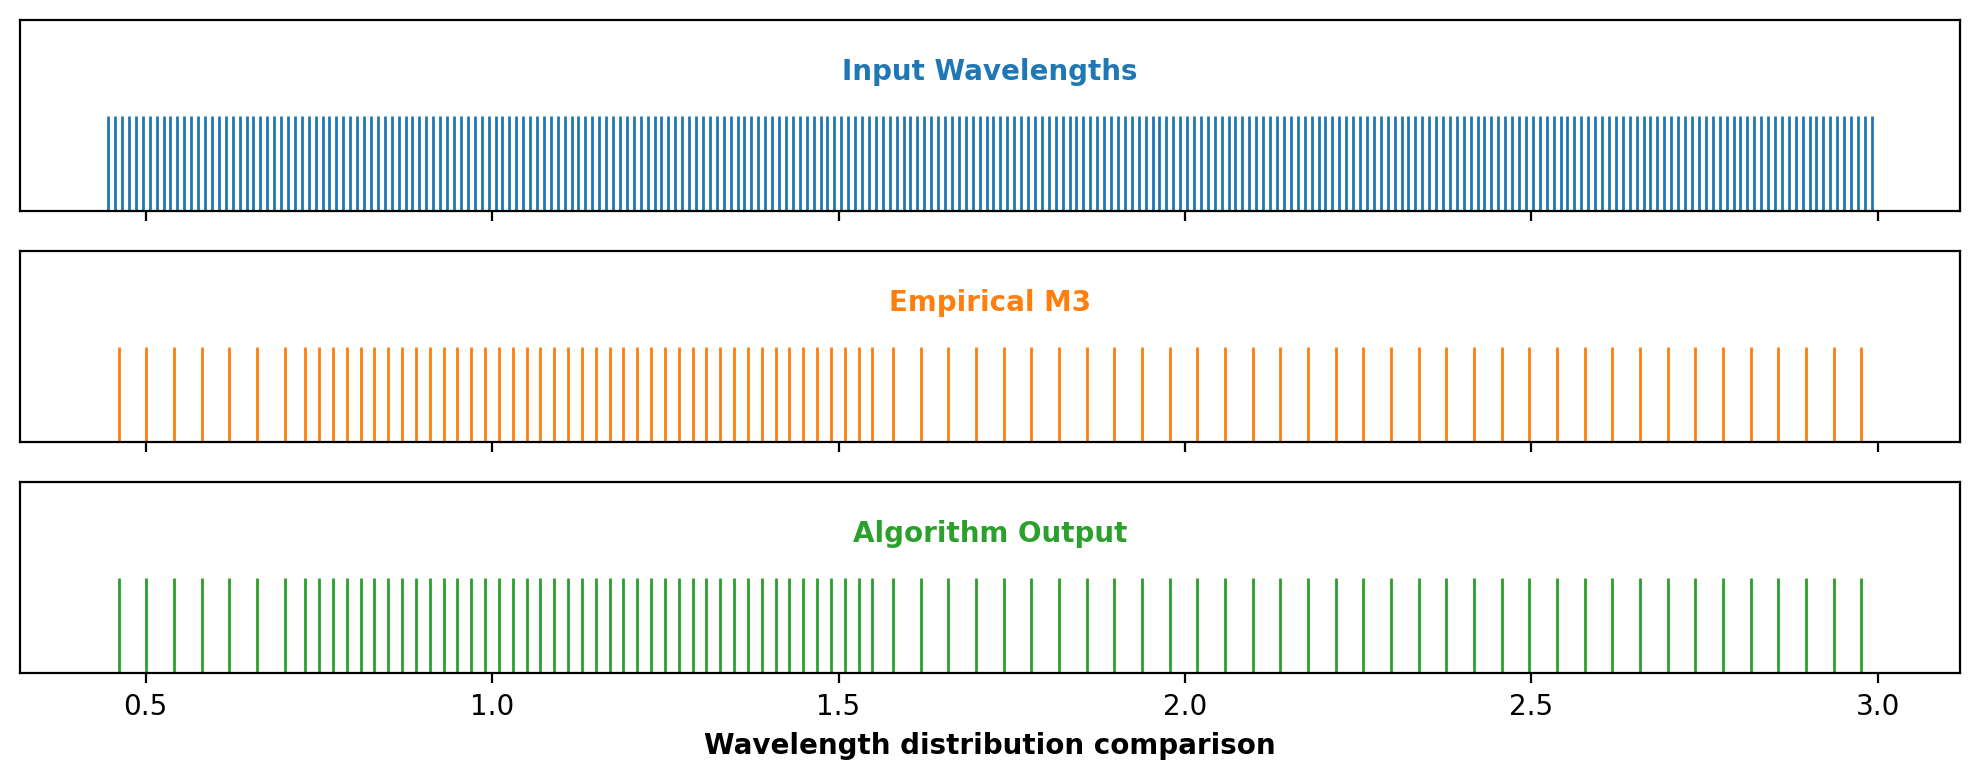

In [16]:
data = {
    "Input Wavelengths": wavelengths, 
    "Empirical M3": empirical, 
    "Algorithm Output": output
}

colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

fig, axes = plt.subplots(
    nrows=3, 
    sharex=True, 
    figsize=(10, 4), 
    height_ratios=[1, 1, 1]
)

# each series as a rug plot with its own row
for ax, (label, series), color in zip(axes, data.items(), colors):
    sns.rugplot(x = series, ax = ax, height = 0.5, color = color)
    ax.set_yticks([])  # No y-axis ticks
    ax.set_ylabel("")
    ax.text(
        0.5, # x offset
        0.8, # y offset
        label, # text content
        # **kwargs
        transform=ax.transAxes, 
        ha='center', 
        va='top', 
        fontsize=10, 
        color=color, 
        weight='bold'
    )

# last plot label acts as legend label
axes[-1].set_xlabel("Wavelength distribution comparison", weight = 'bold') 
plt.tight_layout()

# plt.savefig(
#     "../output files/graphs/test/m3 wavelength comparison.png", 
#     dpi=2000, 
#     bbox_inches='tight',
#     facecolor='white'
# )

plt.show() # calls plt.clf()

In [ ]:
### file writing:

In [17]:
output

array([0.461 , 0.5009, 0.5408, 0.5808, 0.6207, 0.6606, 0.7005, 0.7305,
       0.7504, 0.7704, 0.7904, 0.8103, 0.8303, 0.8502, 0.8702, 0.8902,
       0.9101, 0.9301, 0.9501, 0.97  , 0.99  , 1.0099, 1.0299, 1.0499,
       1.0698, 1.0898, 1.1098, 1.1297, 1.1497, 1.1696, 1.1896, 1.2096,
       1.2295, 1.2495, 1.2694, 1.2894, 1.3094, 1.3293, 1.3493, 1.3693,
       1.3892, 1.4092, 1.4292, 1.4491, 1.4691, 1.489 , 1.509 , 1.529 ,
       1.5489, 1.5789, 1.6188, 1.6587, 1.6986, 1.7386, 1.7785, 1.8184,
       1.8583, 1.8982, 1.9382, 1.9781, 2.018 , 2.058 , 2.0979, 2.1378,
       2.1777, 2.2176, 2.2576, 2.2975, 2.3374, 2.3774, 2.4173, 2.4572,
       2.4971, 2.537 , 2.577 , 2.6169, 2.6568, 2.6967, 2.7366, 2.7766,
       2.8165, 2.8564, 2.8964, 2.9363, 2.9762])